In [1]:
!pip -q install ./python

In [2]:
import numpy as np
import random
import copy
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [14]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [15]:
def train(agent, n_episodes=500, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(2)
        trajectories_states, trajectories_next_states, trajectories_full_states, trajectories_actions, \
        trajectories_log_probs, trajectories_values, trajectories_rewards, \
        trajectories_dones = [], [], [], [], [], [], [], []
        
        while True:
            actions, log_probs = agent.act(states)
            trajectories_states.append(states)
            trajectories_actions.append(actions)
            trajectories_log_probs.append(log_probs)            
           
            # Concatenate all states and actions taken by all agents
            # from agent 0 point of view, concatenate state seen by agent 0, state seen by agent 1, action agent 0, action agent 1
            # from agent 1 point of view, concatenate state seen by agent 1, state seen by agent 0, action agent 1, action agent 0
            full_state = np.zeros((num_agents, (state_size + action_size) * num_agents))
            for i in range(num_agents):
                start = 0
                start_action = state_size * num_agents
                idx = np.arange(num_agents)
                for j in idx:
                    full_state[i][start:start + state_size] += states[j]
                    full_state[i][start_action: start_action + action_size] += actions[j]
                    start += state_size
                    start_action += action_size
                idx = np.roll(idx, -1)
                    
            trajectories_full_states.append(full_state)
            trajectories_values.append(agent.estimate(full_state).squeeze(-1))
                
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]              # send all actions to the environment
            next_states = env_info.vector_observations                            # get next state (for each agent)
            rewards = env_info.rewards                                            # get reward (for each agent)
            dones = env_info.local_done                                           # see if episode finished
            scores_one_episode += rewards
                        
            trajectories_next_states.append(next_states)
            trajectories_rewards.append(rewards)
            trajectories_dones.append(dones)
                
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
        
        # in the optimization of the critic, we need the next values
        trajectories_next_values = trajectories_values.copy()
        for i in range(len(trajectories_next_values)):
            trajectories_next_values[i] = trajectories_next_values[i].copy()
                
        # ensure that the next value of timestep i is the value of timestep i+1           
        trajectories_next_values = np.roll(np.array(trajectories_next_values), -1, axis=0)
        # these values will be used in the calculation of the temporal difference during 
        # the calculation of the advantages. The formula is that if the timestep is done then
        # the temportal difference wouldn't be function of the next values
        # yet, with this gathering approach, the episode is ending when done
        # therefore, terms dones * next_values would always be zero
        # so instead of calculating the next value by producing the full states of the next states
        # we just assign zero to the last next values
        trajectories_next_values[-1]=0

        agent.learn(trajectories_states, 
            trajectories_actions, 
            trajectories_log_probs, 
            trajectories_values, 
            trajectories_rewards, 
            trajectories_next_states,
            trajectories_dones, 
            trajectories_full_states, 
            trajectories_next_values)
        
        score = np.max(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tLast Score: {:.3f}'.
                      format(i_episode, 
                         mean_100, 
                         np.max(scores_window),
                        scores_window[-1]))
            agent.save("eps_{}_avg_{}.pth".format(i_episode, mean_100))
            
        if len(scores_window) >= 100 and np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("final.pth")
            break
    return scores

In [16]:
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, full_state_size, activation=F.relu):
        super().__init__()
        self.actor = FullyConnected([state_size, 32, 32,  action_size], activation=activation)
        self.critic = FullyConnected([full_state_size + action_size, 64, 64, 1], activation=activation)
    
    def forward(self, state):
        return F.tanh(self.actor(state))
    
    def estimate(self, full_state, action):
        """
            The expected input here is the boosted information. That are the states seen by all agents and their actions
        """
        concatenated = torch.cat((full_state, action), dim=-1)
        return self.critic(concatenated)

class Gaussian(nn.Module):
    def __init__(self, state_size, action_size, full_state_size, activation=F.relu):
        super().__init__()
        # This need a change in I:\MyDev\Anaconda3\envs\drlnd\Lib\site-packages\torch\distributions\utils.py
        # at the line 70, check the type using isinstance instead of __class__.__name__
        self.std = torch.nn.Parameter(torch.ones(1, action_size))
        self.actor = FullyConnected([state_size, 32, 32,  action_size], activation=activation)
        self.critic = FullyConnected([full_state_size, 32, 32, 1], activation=activation)
    
    def get_dist(self, state):
        mu = F.tanh(self.actor(state))
        dist = torch.distributions.Normal(mu, self.std)
        return dist
    
    def forward(self, state):
        """
            The actor network gets the parameters of the state inputs
            Then generate a settings mu of a gaussian distribution for each type of action with std as standard deviation
            Afterwards, that distribution is sampled, and we get values for the actions
            That allows us to get also the log probability of the sampled values
            
            When an action is provided, the actor network generates the mu from the state inputs
            We can look then for the log probability of the provided action in regards to the distribution generated by the network
        """
        dist = self.get_dist(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob
    
    def estimate(self, full_state):
        """
            The expected input here is the boosted information. That are the states seen by all agents and their actions
        """
        return self.critic(full_state)
    
    def get_log_probs(self, action, state):
        dist = self.get_dist(state)
        log_prob = dist.log_prob(action)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return log_prob

class FullyConnected(nn.Module):
    def __init__(self, hidden_layers_size, activation=F.relu):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of action space
        """
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.extend([layer_init(nn.Linear(hidden_layers_size[i], hidden_layers_size[i + 1])) for i in range(len(hidden_layers_size) - 1)])
        layer_init(self.hidden_layers[-1], 1e-3)
        self.activation = activation
        
    def forward(self, x):
        """Build a network that maps state to actions."""
        for i in range(len(self.hidden_layers) - 1):
            linear = self.hidden_layers[i]
            x = self.activation(linear(x))
        return self.hidden_layers[-1](x)


In [21]:
class PPO():
    """Interacts with and learns from the environment."""
    
    def __init__(self, network, device,
                 LR=1e-2,
                 WEIGHT_DECAY=1.e-4,
                 GRADIENT_CLIP=1, 
                 EPOCHS=4, 
                 BATCH_SIZE=32,
                GAMMA=0.99,
                GAE_TAU=0.95,
                CLIP_EPSILON=1e-1,
                C1=0.5,
                C2=0.01
                ):
        self.device = device
        self.network = network
        self.optim = optim.Adam(self.network.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self.GRADIENT_CLIP = GRADIENT_CLIP
        self.EPOCHS=EPOCHS
        self.BATCH_SIZE=BATCH_SIZE
        self.GAMMA=GAMMA
        self.CLIP_EPSILON=CLIP_EPSILON
        self.GAE_TAU=GAE_TAU
        self.C1=C1
        self.C2=C2
        self.loss_function = lambda estimated, actual: (estimated - actual)**2
#         self.loss_function = torch.nn.SmoothL1Loss()
#         self.loss_function = F.mse_loss
        self.steps = 0
        self.steps_backprop = 0
    
    def save(self, filename):
        torch.save(self.network.state_dict(), filename)
     
    def load(self, path):
        self.network.load_state_dict(torch.load(path))
    
    def act(self, states):
        """ 
        """
        with torch.no_grad():
            states = torch.tensor(states).float().to(self.device)
            actions, log_probs = self.network(states)
        return actions.cpu().detach().numpy(), log_probs.cpu().detach().numpy()
    
    def estimate(self, full_states):
        """ 
        """
        with torch.no_grad():
            full_states = torch.tensor(full_states).float().to(self.device)
            ret = self.network.estimate(full_states)
        return ret.cpu().detach().numpy()
    
    def learn(self, states, actions, log_probs, values, rewards, next_states, dones, full_states, next_values):
        """
        Noise Reduction: Collect more trajectories and when computing the gradients, use the mean gradient accross all trajectories
        Credit Assignment: 
            instead of using the total sum of the reward, use the cumulated rewards
            gradient = SUM[ SUM(advantage*Gradient(log_prob(a|s) )]
        Importance Sampling -> Surrogate:
            Network theta -> generate action a for log_prob
            Network theta'-> find out how likely is the same action a to be generated by theta'
            Instead of gradient(log_prob(a|s)) use gradient(log_prob' - log_prob)*exp() = gradient(prob'/prob)
                This is about re-weighting factor
            Need to understand Importance Sampling and the how to apply it to probabilities
        Clip Surrogate
            apply a gradient which is always less than 1+epsilon of the ration
        """
        states = torch.tensor(states, device=self.device, dtype=torch.float32, requires_grad=False)
        actions = torch.tensor(actions, device=self.device, dtype=torch.float32, requires_grad=False)
        log_probs = torch.tensor(log_probs, device=self.device, dtype=torch.float32, requires_grad=False)
        values = torch.tensor(values, device=self.device, dtype=torch.float32, requires_grad=False)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32, requires_grad=False)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32, requires_grad=False)
        dones = 1 - torch.tensor(dones, device=self.device, dtype=torch.float32, requires_grad=False)
        full_states = torch.tensor(full_states, device=self.device, dtype=torch.float32, requires_grad=False)
        next_values = torch.tensor(next_values, device=self.device, dtype=torch.float32, requires_grad=False)
        
        self.steps += 1
        
        returns = next_values[-1]

        advantages = [None] * actions.shape[0]
        returns_array = [None] * actions.shape[0]
        advantage = torch.zeros(rewards[0].shape, device=self.device, dtype=torch.float32)
        
        assert returns.shape == rewards[-1].shape, "{} != {}".format(returns.shape, rewards[-1].shape)
        assert dones[-1].shape == rewards[-1].shape, "{} != {}".format(dones[-1].shape, rewards[-1].shape)
        assert next_values[-1].shape == dones[-1].shape, "{} != {}".format(next_values[-1].shape, dones[-1].shape)
        assert advantage.shape == dones[-1].shape, "{} != {}".format(advantage.shape, dones[-1].shape)

        for i in reversed(range(states.shape[0])):
            returns = rewards[i] + self.GAMMA*returns*dones[i]
            returns_array[i]=returns.unsqueeze(0).detach()

            # according to the implementation of ShangTong and to the paper 
            # High Dimensional Continuous Control Using Generalized Advantage Estimation from arxiv
            td_error = rewards[i] + self.GAMMA * dones[i] * next_values[i] - values[i]
            assert advantage.shape == td_error.shape, "{} != {}".format(advantage.shape, td_error.shape)
            
            advantage = advantage * self.GAE_TAU * self.GAMMA * dones[i] + td_error
            advantages[i] = advantage.unsqueeze(0).detach()

        returns_array = torch.cat(returns_array, dim=0)
        advantages = torch.cat(advantages, dim=0).unsqueeze(-1)
        advantages = (advantages - advantages.mean()) / advantages.std()
        
        # prepare states, actions, returns,
        for epoch in range(self.EPOCHS):
            # Shuffle the indices
            for indices in self.batch_indices(len(states), self.BATCH_SIZE):
                idx = torch.tensor(indices).long()
                sampled_states = states[idx]
                sampled_full_states = full_states[idx]
                sampled_actions = actions[idx]         
                sampled_log_probs = log_probs[idx].detach()
                sampled_advantages = advantages[idx]
                sampled_returns = returns_array[idx].detach()
                
                # find out how likely the new network would have chosen the sampled_actions at the given sampled_states
                new_log_probs = self.network.get_log_probs(sampled_actions, sampled_states)
            
                assert new_log_probs.shape == sampled_log_probs.shape, "{} != {}".format(new_log_probs.shape, sampled_log_probs.shape)
                assert sampled_advantages.shape == sampled_log_probs.shape, "{} != {}".format(sampled_advantages.shape, sampled_log_probs.shape)
                ratio = (new_log_probs - sampled_log_probs).exp()
                clip = torch.clamp(ratio, 1-self.CLIP_EPSILON, 1+self.CLIP_EPSILON)
                clipped_surrogate = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
                
                # This entropy is included in the calculation of the gradient based on
                # Udacity notebook of Pong-PPO under the chapter of Policy Gradient
                # https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#ppo
                # the paper, https://arxiv.org/pdf/1707.06347.pdf
                # and arxiv insight https://www.youtube.com/watch?v=5P7I-xPq8u8
                # to promote exploration
                entropy = -(new_log_probs.exp()*sampled_log_probs) 
                
                estimated_values = self.network.estimate(sampled_full_states).squeeze(-1)
                
                assert estimated_values.shape == sampled_returns.shape, "{} != {}".format(estimated_values
.shape, sampled_returns.shape)
                value_loss = self.loss_function(estimated_values, sampled_returns)
                
                self.optim.zero_grad()
                value_loss = value_loss.unsqueeze(-1)
                assert clipped_surrogate.shape == value_loss.shape, "{} != {}".format(clipped_surrogate.shape, value_loss.shape)
                assert entropy.shape == value_loss.shape, "{} != {}".format(entropy.shape, value_loss.shape)
                total_loss = - (clipped_surrogate - self.C1 * value_loss + self.C2 * entropy).mean()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.GRADIENT_CLIP)
                self.optim.step()
                
                self.steps_backprop += 1
                
                del idx, sampled_states, sampled_actions
                del sampled_log_probs, sampled_advantages, sampled_returns
                del new_log_probs, ratio, clip, clipped_surrogate, estimated_values, value_loss, entropy

        del states, actions, log_probs, values, rewards, next_states, dones, returns, advantages, returns_array
    
    def batch_indices(self, length, batch_size):
        indices = np.arange(length)
        np.random.shuffle(indices)
        for i in range(1 + length // batch_size):
            start = batch_size*i
            end = start + batch_size
            end = min(length, end)
            if start >= length:
                return
            yield indices[start:end]

In [18]:
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    θ_target = θ_target + τ*(θ_local - θ_target)
    θ_local = r + gamma * θ_local(s+1)
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    # this is transferring gradually the parameters of the online Q Network to the fixed one
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class SimpleNoise:
    def __init__(self, size, scale = 1.0):
        self.size = size
        self.scale = scale
        
    def reset(self):
        pass
    
    def sample(self):
        return self.scale * np.random.randn(self.size)
        
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.device = device
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, device, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
       
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        return self.to_tensor(experiences)
    
    def shuffle_all(self):
        temp = list(self.memory)
        random.shuffle(temp)
        batch_count = int(len(temp) / self.batch_size)
        for a in range(batch_count):
            yield self.to_tensor(temp[a:(a+1)*self.batch_size])
    
    def to_tensor(self, experiences):
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device).requires_grad_(False)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(self.device).requires_grad_(False)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device).requires_grad_(False)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device).requires_grad_(False)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device).requires_grad_(False)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [19]:
env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]

Episode 50	Average Score: 0.020	Max Score: 0.100	Last Score: 0.000
Episode 100	Average Score: 0.019	Max Score: 0.100	Last Score: 0.000
Episode 150	Average Score: 0.014	Max Score: 0.100	Last Score: 0.000
Episode 200	Average Score: 0.010	Max Score: 0.100	Last Score: 0.000
Episode 250	Average Score: 0.010	Max Score: 0.100	Last Score: 0.000
Episode 300	Average Score: 0.017	Max Score: 0.100	Last Score: 0.000
Episode 350	Average Score: 0.018	Max Score: 0.100	Last Score: 0.090
Episode 400	Average Score: 0.017	Max Score: 0.200	Last Score: 0.000
Episode 450	Average Score: 0.022	Max Score: 0.200	Last Score: 0.000
Episode 500	Average Score: 0.015	Max Score: 0.200	Last Score: 0.000
Episode 550	Average Score: 0.014	Max Score: 0.100	Last Score: 0.000
Episode 600	Average Score: 0.025	Max Score: 0.200	Last Score: 0.100
Episode 650	Average Score: 0.034	Max Score: 0.200	Last Score: 0.000
Episode 700	Average Score: 0.033	Max Score: 0.200	Last Score: 0.000
Episode 750	Average Score: 0.026	Max Score: 0.100

Episode 6050	Average Score: 0.058	Max Score: 0.100	Last Score: 0.090
Episode 6100	Average Score: 0.064	Max Score: 0.100	Last Score: 0.000
Episode 6150	Average Score: 0.063	Max Score: 0.100	Last Score: 0.000
Episode 6200	Average Score: 0.062	Max Score: 0.100	Last Score: 0.000
Episode 6250	Average Score: 0.059	Max Score: 0.100	Last Score: 0.000
Episode 6300	Average Score: 0.061	Max Score: 0.100	Last Score: 0.000
Episode 6350	Average Score: 0.069	Max Score: 0.100	Last Score: 0.000
Episode 6400	Average Score: 0.061	Max Score: 0.100	Last Score: 0.000
Episode 6450	Average Score: 0.063	Max Score: 0.100	Last Score: 0.090
Episode 6500	Average Score: 0.067	Max Score: 0.100	Last Score: 0.100
Episode 6550	Average Score: 0.057	Max Score: 0.100	Last Score: 0.000
Episode 6600	Average Score: 0.055	Max Score: 0.200	Last Score: 0.200
Episode 6650	Average Score: 0.056	Max Score: 0.200	Last Score: 0.090
Episode 6700	Average Score: 0.059	Max Score: 0.190	Last Score: 0.000
Episode 6750	Average Score: 0.063	

Episode 12000	Average Score: 0.107	Max Score: 0.200	Last Score: 0.100
Episode 12050	Average Score: 0.109	Max Score: 0.290	Last Score: 0.100
Episode 12100	Average Score: 0.128	Max Score: 0.300	Last Score: 0.100
Episode 12150	Average Score: 0.131	Max Score: 0.400	Last Score: 0.200
Episode 12200	Average Score: 0.112	Max Score: 0.400	Last Score: 0.090
Episode 12250	Average Score: 0.101	Max Score: 0.200	Last Score: 0.190
Episode 12300	Average Score: 0.110	Max Score: 0.200	Last Score: 0.190
Episode 12350	Average Score: 0.110	Max Score: 0.200	Last Score: 0.100
Episode 12400	Average Score: 0.104	Max Score: 0.300	Last Score: 0.100
Episode 12450	Average Score: 0.115	Max Score: 0.300	Last Score: 0.100
Episode 12500	Average Score: 0.117	Max Score: 0.300	Last Score: 0.000
Episode 12550	Average Score: 0.118	Max Score: 0.300	Last Score: 0.200
Episode 12600	Average Score: 0.120	Max Score: 0.300	Last Score: 0.000
Episode 12650	Average Score: 0.115	Max Score: 0.500	Last Score: 0.100
Episode 12700	Averag

Episode 17900	Average Score: 0.037	Max Score: 0.300	Last Score: 0.190
Episode 17950	Average Score: 0.045	Max Score: 0.200	Last Score: 0.100
Episode 18000	Average Score: 0.042	Max Score: 0.200	Last Score: 0.000
Episode 18050	Average Score: 0.034	Max Score: 0.200	Last Score: 0.000
Episode 18100	Average Score: 0.034	Max Score: 0.200	Last Score: 0.190
Episode 18150	Average Score: 0.038	Max Score: 0.200	Last Score: 0.000
Episode 18200	Average Score: 0.033	Max Score: 0.200	Last Score: 0.100
Episode 18250	Average Score: 0.024	Max Score: 0.200	Last Score: 0.000
Episode 18300	Average Score: 0.024	Max Score: 0.200	Last Score: 0.000
Episode 18350	Average Score: 0.029	Max Score: 0.200	Last Score: 0.000
Episode 18400	Average Score: 0.032	Max Score: 0.200	Last Score: 0.000
Episode 18450	Average Score: 0.033	Max Score: 0.200	Last Score: 0.100
Episode 18500	Average Score: 0.038	Max Score: 0.200	Last Score: 0.000
Episode 18550	Average Score: 0.064	Max Score: 0.700	Last Score: 0.000
Episode 18600	Averag

Episode 23800	Average Score: 0.196	Max Score: 0.600	Last Score: 0.200
Episode 23850	Average Score: 0.168	Max Score: 0.400	Last Score: 0.190
Episode 23900	Average Score: 0.174	Max Score: 0.600	Last Score: 0.100
Episode 23950	Average Score: 0.187	Max Score: 0.700	Last Score: 0.200
Episode 24000	Average Score: 0.177	Max Score: 0.700	Last Score: 0.200
Episode 24050	Average Score: 0.157	Max Score: 0.390	Last Score: 0.300
Episode 24100	Average Score: 0.144	Max Score: 0.300	Last Score: 0.000
Episode 24150	Average Score: 0.175	Max Score: 0.600	Last Score: 0.000
Episode 24200	Average Score: 0.208	Max Score: 0.600	Last Score: 0.190
Episode 24250	Average Score: 0.219	Max Score: 0.600	Last Score: 0.100
Episode 24300	Average Score: 0.218	Max Score: 0.700	Last Score: 0.100
Episode 24350	Average Score: 0.222	Max Score: 0.700	Last Score: 0.200
Episode 24400	Average Score: 0.244	Max Score: 0.600	Last Score: 0.200
Episode 24450	Average Score: 0.230	Max Score: 0.600	Last Score: 0.200
Episode 24500	Averag

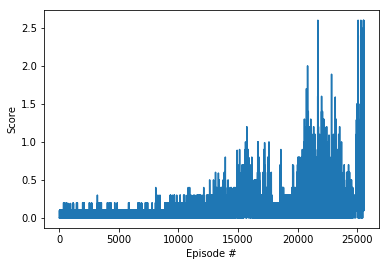

In [22]:
# I don't have much GPU hours left and it's not a big difference for RL
device = "cpu"

seed = 257
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

network = Gaussian(state_size, action_size, (state_size + action_size)*2 , activation = F.leaky_relu).to(device)
agent = PPO(network, device,
                 LR=3e-4,
                 WEIGHT_DECAY=1e-4,
                 GRADIENT_CLIP=5, 
                 EPOCHS=3, 
                 BATCH_SIZE=256,
                GAMMA=0.99,
                GAE_TAU=0.99,
                CLIP_EPSILON=0.1,
                C1=0.5,
                C2=0.01)
scores = train(agent, n_episodes=60000, train_mode=True)
plot_result(scores)